#Nonlinear Temporal Dynamics of a Strongly Coupled Quantum-Dot–Cavity System

In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
%matplotlib inline

In [3]:
def gaussian(t):
    #Ω0 = args[2] # Pulse Area!
    t0 = 10.0 # Time for maximum -> Mean value of the Gaussian distribution!
    F = 5.0 # Full-Width at Half-Maximum!
    σs = 0.42*F
    #Omega = (Ω0/(np.sqrt(2*np.pi)*σs))*np.exp(-0.5*((t-t0)/σs)**2)
    #Ω = (1.0/(np.sqrt(2*np.pi)*σs))*np.exp(-0.5*((t-t0)/σs)**2)
    Ω = np.exp(-0.5*((t-t0)/σs)**2)
    return Ω    

In [4]:
def hamiltonian_t(t, args):
    """ evaluate the hamiltonian at time t. """
    # Time units are (ps)! So, frequencies are in (THz)!
    H0 = args[0]
    H1 = args[1]
    Ω = gaussian(t)
    return H0 + Ω*H1

In [5]:
def qubit_integrate(n, Δa, Δc, g, Ω0, κ, γ, ψ0, tlist):

    # Hamiltonian
    a = tensor(identity(2),destroy(n))
    σ = tensor(destroy(2),identity(n))
    
    #a = tensor(destroy(n),identity(2))
    #σ = tensor(identity(n),destroy(2))

    H0 = Δa*σ.dag()*σ + Δc*a.dag()*a + 1j*g*(a.dag()*σ - a*σ.dag())
    H1 = 1j*Ω0*(a-a.dag())

    # collapse operators
    c_op_list = []

    # Cavity photons dissipation (a)
    if κ > 0.0:
        c_op_list.append( np.sqrt(κ)*a )

    # Spontaneous emission
    if γ > 0.0:
        c_op_list.append( np.sqrt(γ)*σ )

    # evolve and calculate expectation values

    # method 1: function callback which returns the time-dependent qobj
    H_args = (H0, H1)
    output = mesolve(hamiltonian_t, ψ0, tlist, c_op_list, [a], H_args)  

    # method 2: a function callback that returns the coefficient for a qobj
    #H = [H0, [H1, lambda x,y: x]]
    #output = mesolve(H, psi0, tlist, c_op_list, [sm.dag() * sm], {})  

    # method 3: a string that defines the coefficient. The solver generates
    # and compiles C code using cython. This method is usually the fastest
    # for large systems or long time evolutions, but there is fixed-time
    # overhead that makes it inefficient for small and short-time evolutions.
    #H = [H0, [H1, 't']]
    #output = mesolve(H, psi0, tlist, c_op_list, [sm.dag() * sm], {})  

    return output.expect[0]

In [55]:
def calc_spectrum(n, Δa, Δc, g, Ω0, κ, γ, tlist, wlist):

    # Hamiltonian
    a = tensor(identity(2),destroy(n))
    σ = tensor(destroy(2),identity(n))
    
    #a = tensor(destroy(n),identity(2))
    #σ = tensor(identity(n),destroy(2))

    H0 = Δa*σ.dag()*σ + Δc*a.dag()*a + 1j*g*(a.dag()*σ - a*σ.dag())
    H1 = 1j*Ω0*(a-a.dag())
    
    #Ω = gaussian(t)
    #H = H0 + Ω*H1
    

    # collapse operators
    c_op_list = []

    # Cavity photons dissipation (a)
    if κ > 0.0:
        c_op_list.append( np.sqrt(κ)*a )

    # Spontaneous emission
    if γ > 0.0:
        c_op_list.append( np.sqrt(γ)*σ )

    # evolve and calculate expectation values

    # method 1: function callback which returns the time-dependent qobj
    H_args = (H0, H1)

    A = a.dag() + a
    B = A
    
    # calculate the power spectrum
    #corr = correlation_ss(hamiltonian_t, tlist, c_op_list, A, B, H_args)  

    # calculate the power spectrum
    spec = spectrum_ss(hamiltonian_t, wlist, c_op_list, A, B, H_args)  

    return spec#, corr

time elapsed = 0.5810706615447998


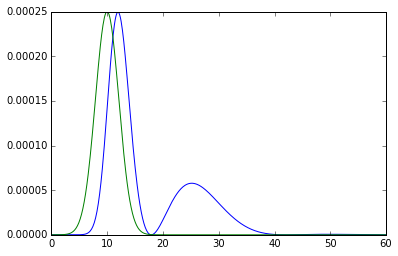

In [12]:
#
# Set up the calculation
#
π = np.pi

n = 40 # Number of photons

# I'm not sure about the detuning numbers!!!
# δ = Δc -Δa, if Δa = 0, δ = Δc!
Δc = 0.0e-3*(2*π)#2.25e-6 #2.0e-3*(2*π) # Detuning between the laser frequency and the cavity frequency
Δa = 0.0e-3*(2*π) # Detuning between the laser frequency and the QD frequency

g = 25.0e-3*(2*π)   #25e-3*(2*π) # Coherent interaction strength between the QD and the cavity
Ω0 = 1.0e-3*(2*π)   #1e-3*(2*π) # Peak intensity of the driving pulse. Not the Pulse Area!(A0): A0 = \sqrt(2π)σ Ω_0
κ = 2*29.0e-3*(2*π)   #29e-3*(2*π) # Dissipation of the cavity field to the environment decay rate (a)
γ = 2*1.0e-3*(2*π)    #1e-3*(2*π) # Dipole spontaneous emission rate (σ)
ψ0 = tensor(basis(2,0),fock(n,0)) # initial state

N = 500 # Number of time points
tlist = np.linspace(0.0, 60.0, N)

start_time = time.time()
p_ex = qubit_integrate(n, Δa, Δc, g, Ω0, κ, γ, ψ0, tlist)
print('time elapsed = ' + str(time.time() - start_time))

plt.plot(tlist,np.real(p_ex)**2+np.imag(p_ex)**2)
plt.plot(tlist,gaussian(tlist)*2.5e-4)

In [57]:
#
# Spectrum calculation
#
π = np.pi

n = 40 # Number of photons

# I'm not sure about the detuning numbers!!!
# δ = Δc -Δa, if Δa = 0, δ = Δc!
Δc = 0.0e-3*(2*π)#2.25e-6 #2.0e-3*(2*π) # Detuning between the laser frequency and the cavity frequency
Δa = 0.0e-3*(2*π) # Detuning between the laser frequency and the QD frequency

g = 25.0e-3*(2*π)   #25e-3*(2*π) # Coherent interaction strength between the QD and the cavity
Ω0 = 30.0e-3*(2*π)   #1e-3*(2*π) # Peak intensity of the driving pulse. Not the Pulse Area!(A0): A0 = \sqrt(2π)σ Ω_0
κ = 29.0e-3*(2*π)   #29e-3*(2*π) # Dissipation of the cavity field to the environment decay rate (a)
γ = 1.0e-3*(2*π)    #1e-3*(2*π) # Dipole spontaneous emission rate (σ)

N = 500 # Number of time points
wlist = np.linspace(0, 2*π, N/2)
tlist = np.linspace(0, 60, N)

start_time = time.time()
spec1 = calc_spectrum(n, Δa, Δc, g, Ω0, κ, γ, tlist, wlist)
spec2 = calc_spectrum(n, Δa, Δc, g, Ω0, κ, γ, tlist, wlist)
print('time elapsed = ' + str(time.time() - start_time))

#figure(figsize=(9, 4))
plt.plot(wlist/(2*π), np.abs(spec1), 'b', lw=2)
plt.plot(wlist/(2*π), np.abs(spec2), 'r', lw=2)

TypeError: spectrum_ss() takes 5 positional arguments but 6 were given

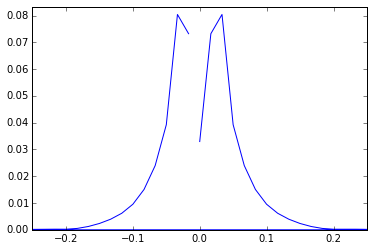

In [39]:
import numpy as np
from scipy.fftpack import rfft, irfft, fftfreq, fft

W = fftfreq(p_ex.size, d=(tlist[1]-tlist[0]))
f_signal = fft(p_ex)

plt.plot(W,1/N*np.abs(f_signal))
plt.axis([-150/N,150/N,0,50/N]);

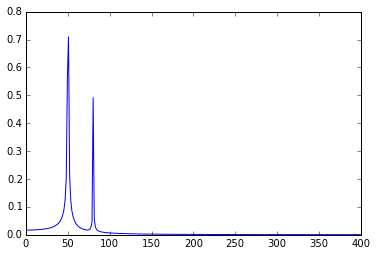

In [37]:
import scipy.fftpack

# Number of samplepoints
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[0:N/2]))

In [20]:
len(W)

5000